In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

* Reading Data

In [2]:
df = pd.read_csv("adjusted_data.csv")

In [3]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Converting Categorical Data to Numerical Format

In [4]:
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

In [5]:
all_columns = list(df.columns)

# Check nulls & duplicates

In [6]:
df.duplicated().sum()
df.isnull().sum().mean()

np.float64(0.0)

no doublicates

no nulls

### Feature Distributions using `histplot`

In this section, we visualize the statistical distributions of all numerical features using the updated `sns.histplot` function from Seaborn.  
Each subplot displays one feature’s histogram along with its kernel density estimate (KDE) curve.  
This helps in:
- Understanding the shape of data (normal or skewed)
- Detecting potential outliers
- Identifying features that may need normalization or scaling

The plots are arranged in a 10×3 grid for clear visualization of the first 30 features.

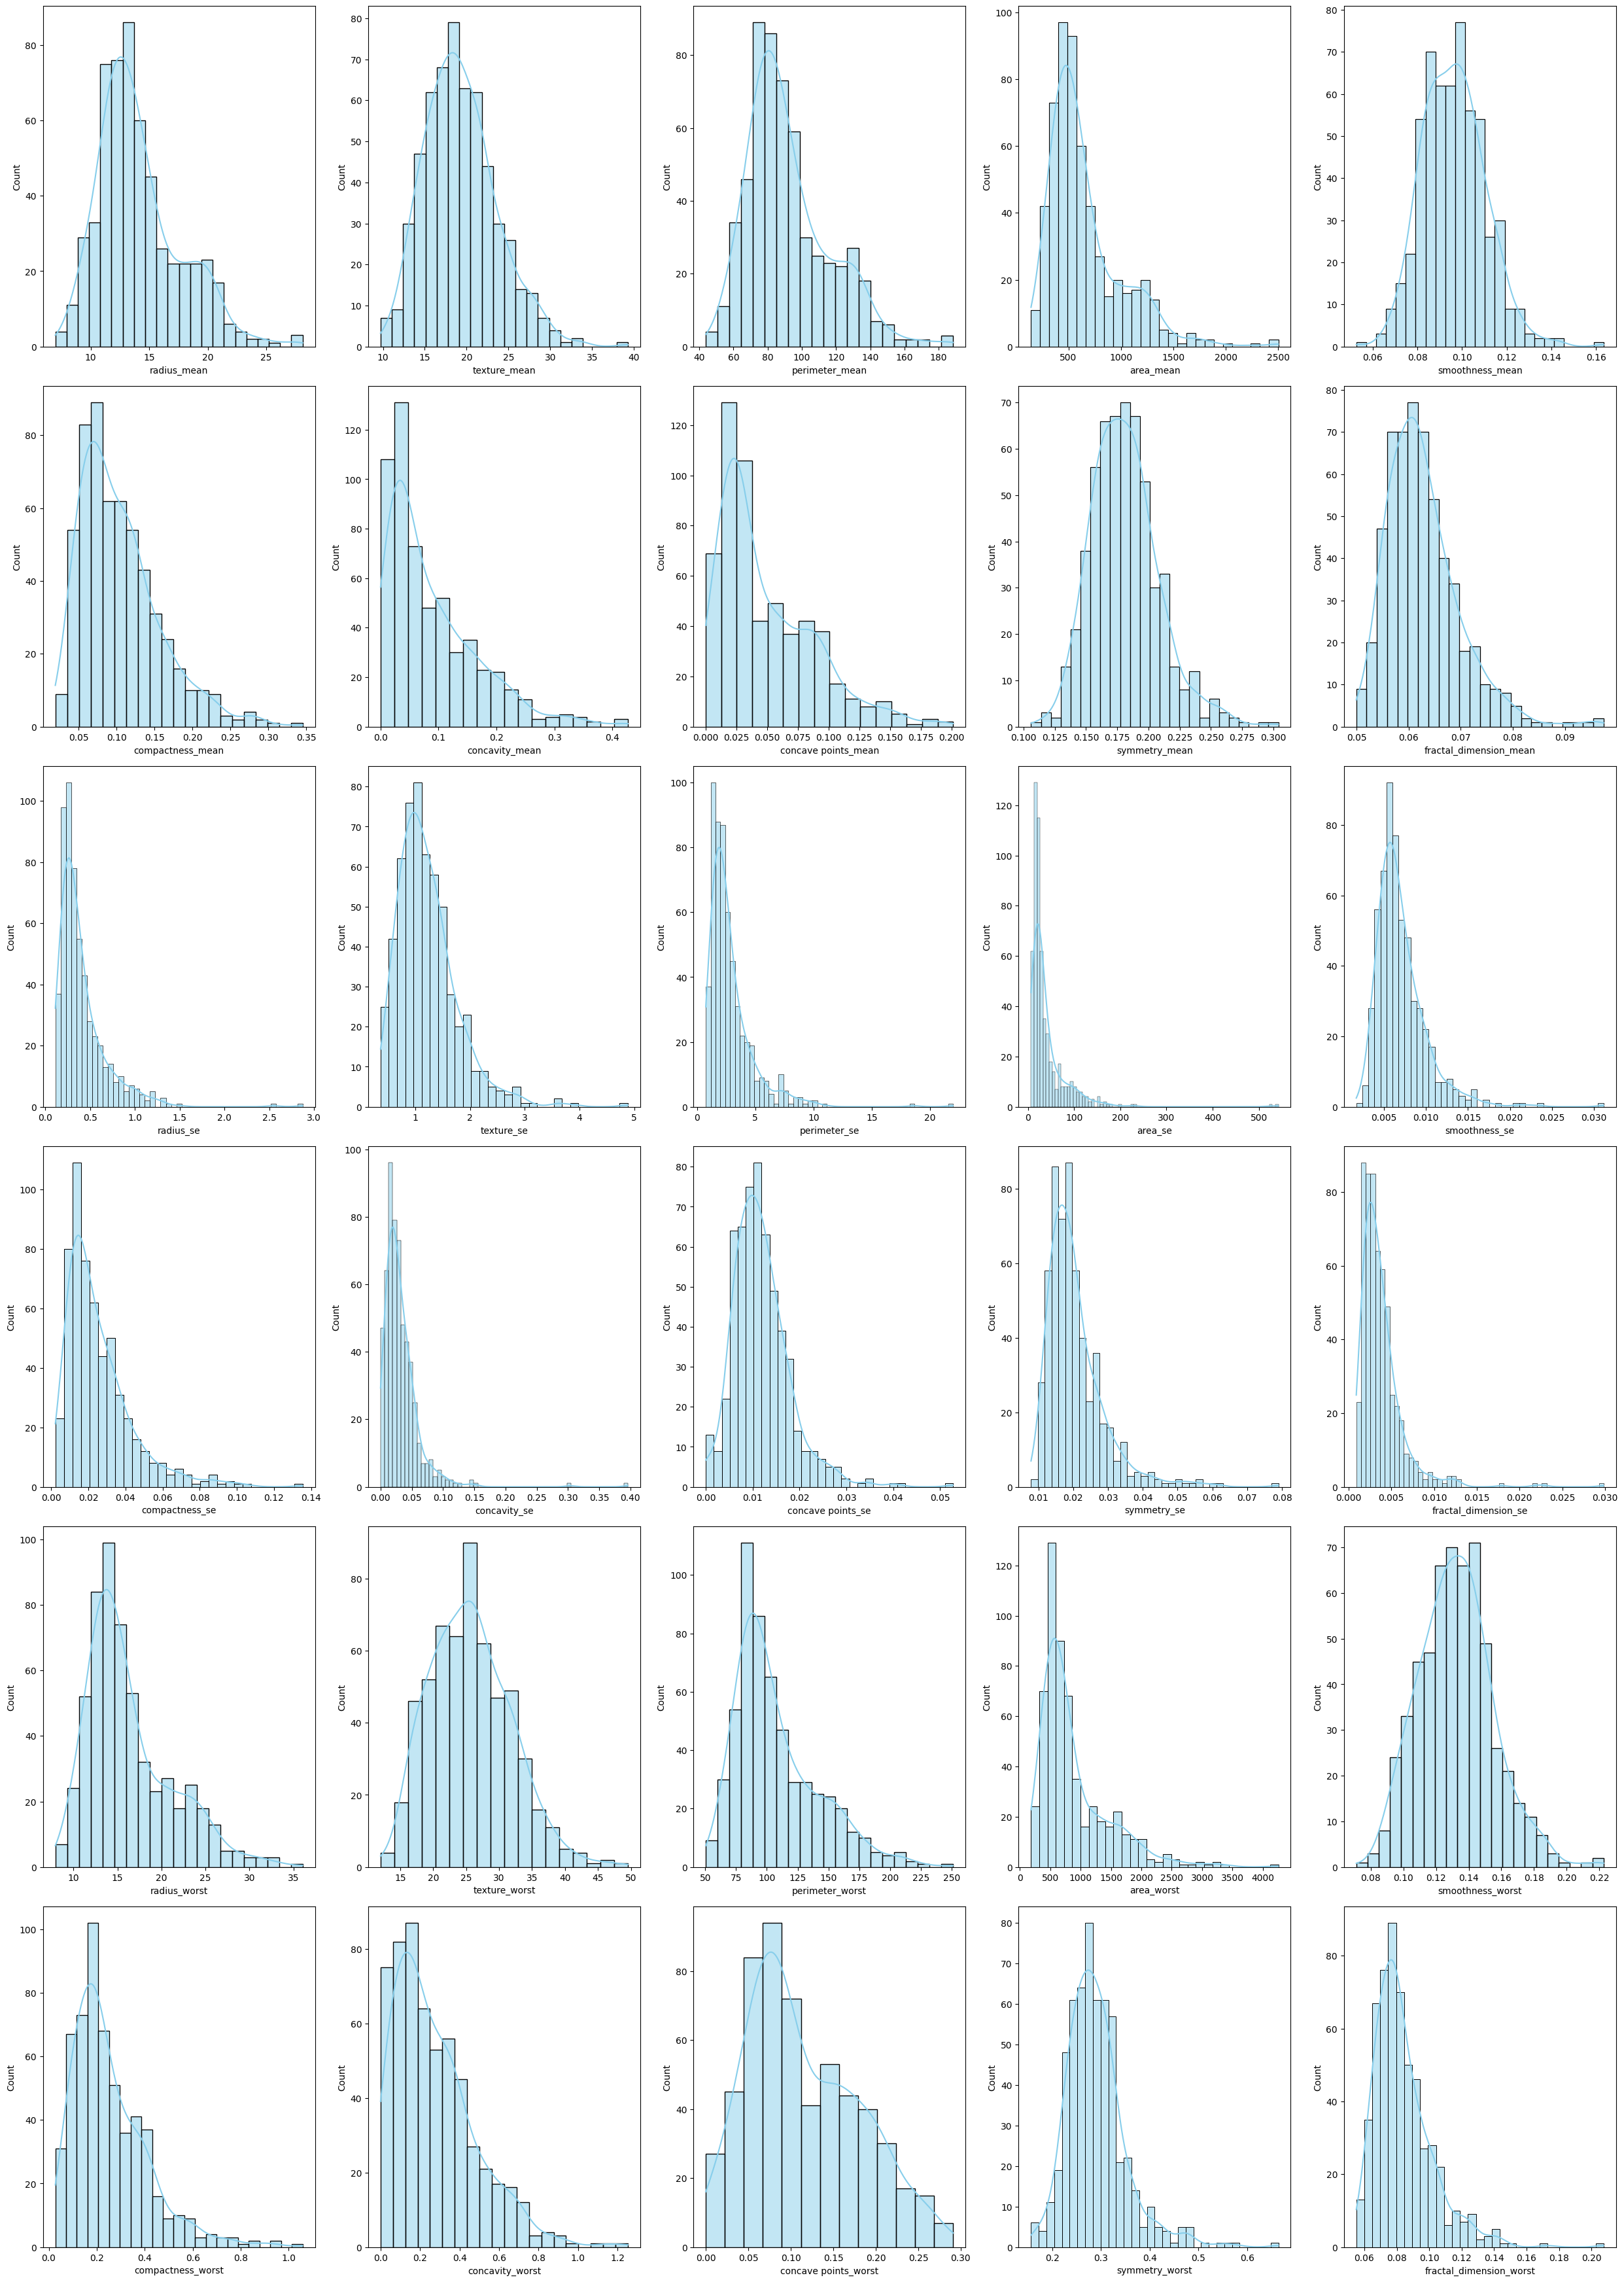

In [8]:
plt.figure(figsize=(25, 35))
cols = all_columns[1:]  # excluding the diagnosis column
for i in range(30):
    plt.subplot(6, 5, i + 1)
    sns.histplot(df[cols[i]], kde=True, color='skyblue')
plt.tight_layout()
plt.show()

**Highly skewed features**
* features > 75% == (24 features)
* Features with |skewness| > 0.75 are considered significantly skewed.

Depending on the skew type:

* Right-skewed (positive) → apply np.log1p() or np.sqrt()

* Left-skewed (negative) → use a Power Transform (Yeo-Johnson)

* After transformation, the distributions become more symmetric and suitable for modeling.

In [9]:
skewness = df[cols].skew().sort_values(ascending=False)

high_skew = skewness[abs(skewness) > 0.75]

print("Highly skewed features:\n", high_skew)
high_skew.count()

Highly skewed features:
 area_se                    5.447186
concavity_se               5.110463
fractal_dimension_se       3.923969
perimeter_se               3.443615
radius_se                  3.088612
smoothness_se              2.314450
symmetry_se                2.195133
compactness_se             1.902221
area_worst                 1.859373
fractal_dimension_worst    1.662579
texture_se                 1.646444
area_mean                  1.645732
compactness_worst          1.473555
concave points_se          1.444678
symmetry_worst             1.433928
concavity_mean             1.401180
fractal_dimension_mean     1.304489
compactness_mean           1.190123
concave points_mean        1.171180
concavity_worst            1.150237
perimeter_worst            1.128164
radius_worst               1.103115
perimeter_mean             0.990650
radius_mean                0.942380
dtype: float64


np.int64(24)

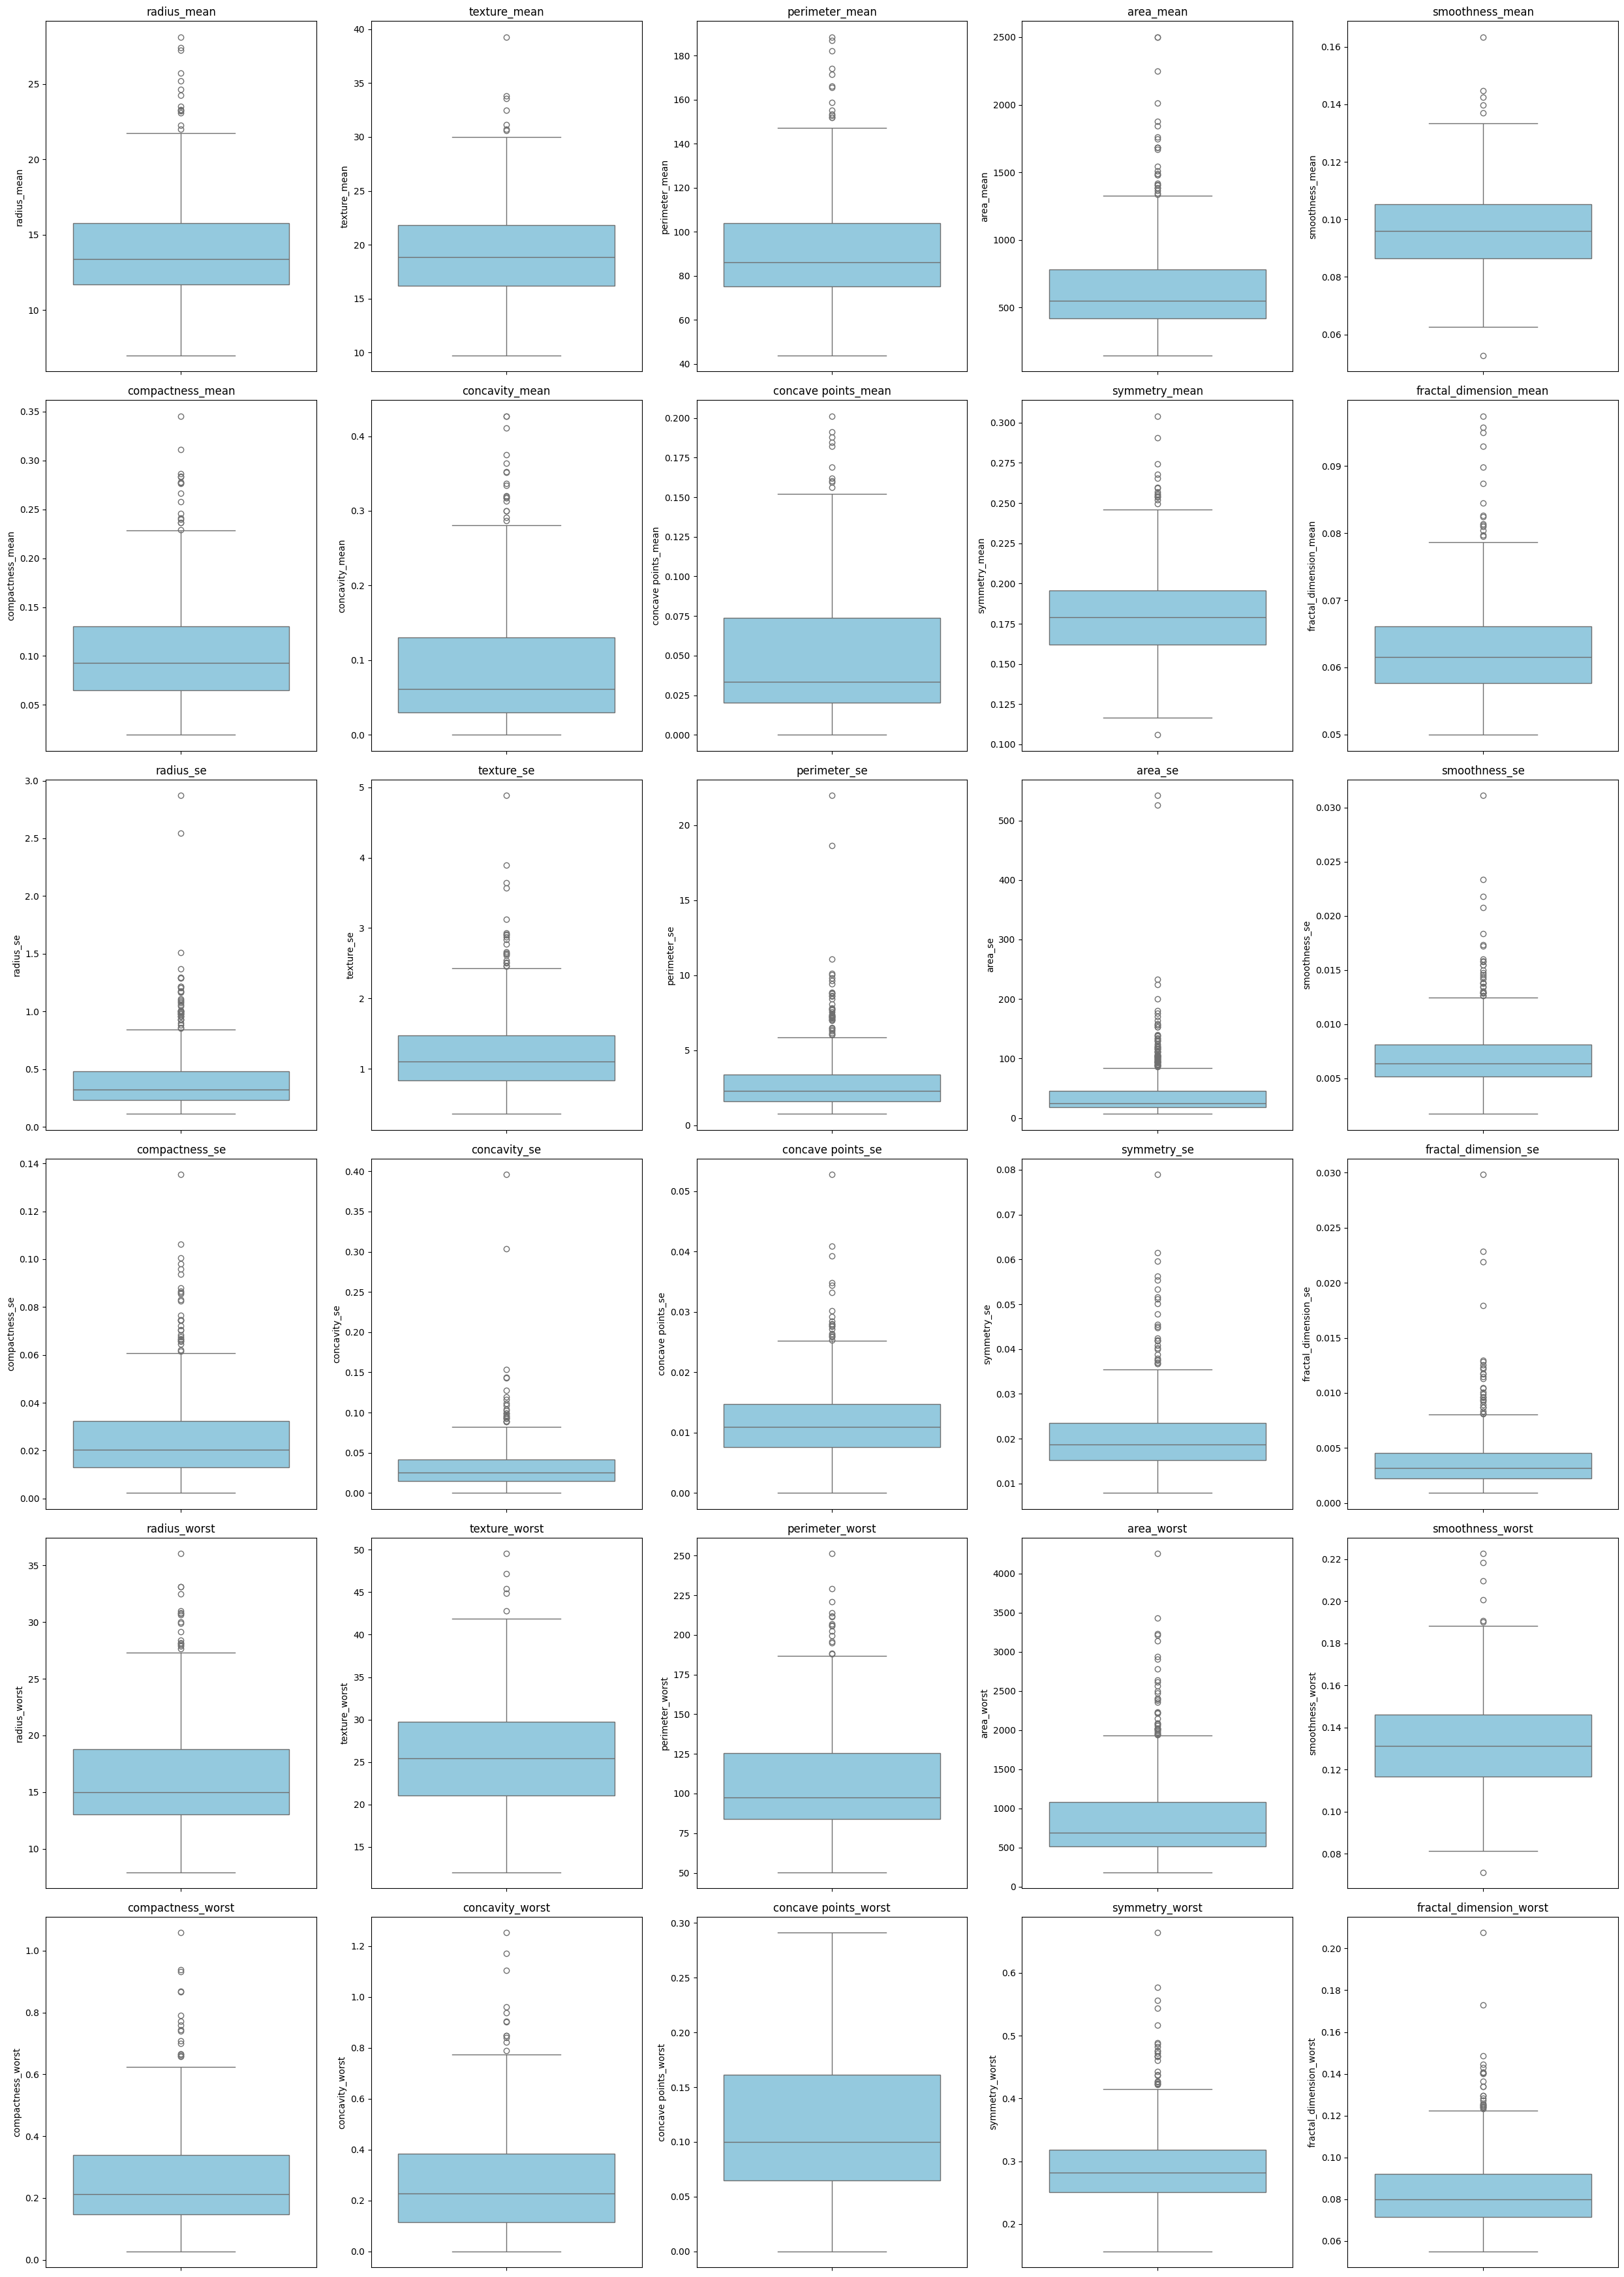

In [10]:
plt.figure(figsize=(25, 35))
cols = all_columns[1:]

for i in range(30):
    plt.subplot(6, 5, i + 1)
    sns.boxplot(y=df[cols[i]], color='skyblue')
    plt.title(cols[i])

plt.tight_layout()
plt.show()

**heatmap Visualization of Correlation Matrix**
* To visualize the correlation between all numerical features, a heatmap is used.
This helps identify strong positive or negative relationships between variables.
Highly correlated features (close to +1 or -1) may cause redundancy and can be removed to simplify the model.

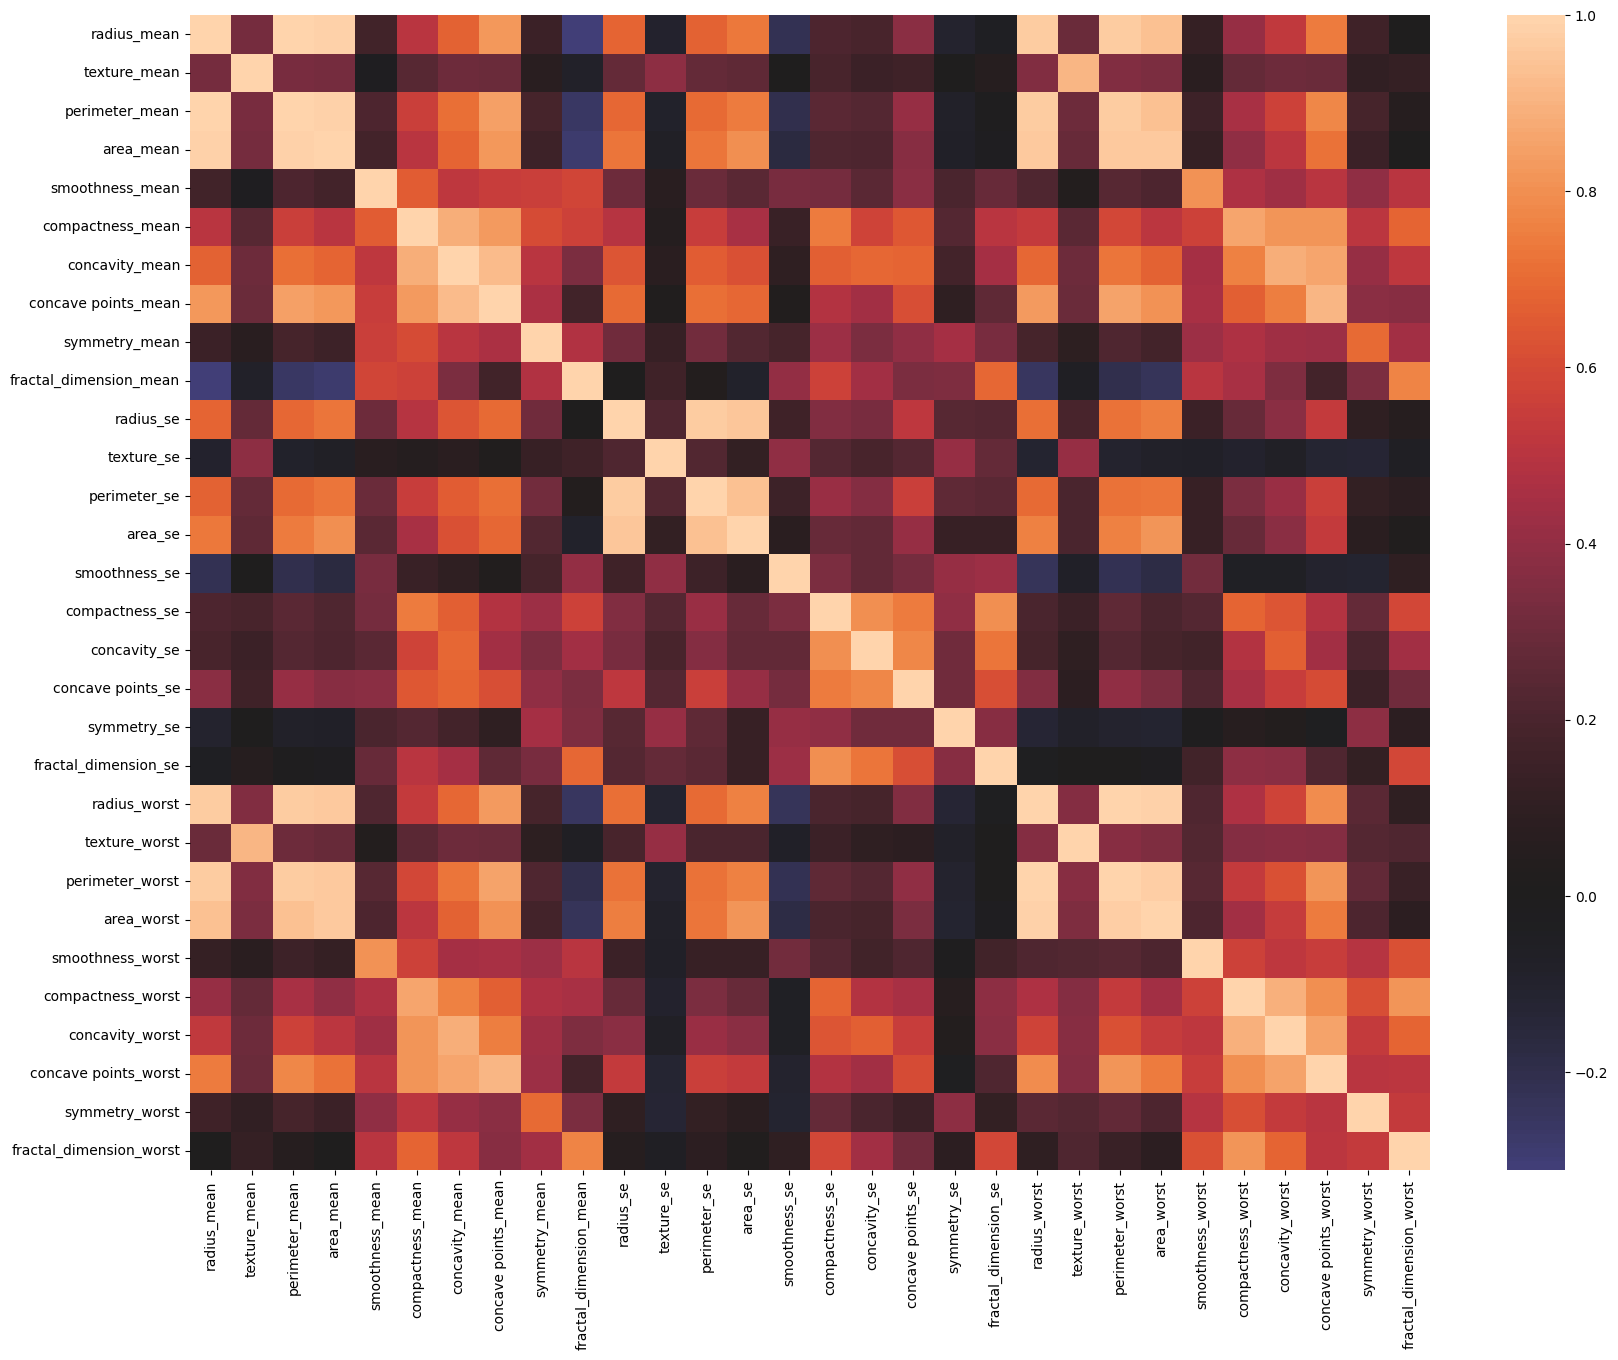

In [11]:
plt.figure(figsize=(20,15))
sns.heatmap(df[all_columns[1:]].corr(), center=0)
plt.show()

In this step, we calculate the correlation matrix to identify highly correlated features.
Features with a correlation coefficient greater than 0.9 are considered redundant, as they provide similar information.
To reduce multicollinearity and improve model performance, these features will be dropped.

In [12]:
corr_matrix = df.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.90)]
print("Highly correlated columns:", to_drop)

Highly correlated columns: ['perimeter_mean', 'area_mean', 'concave points_mean', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']


In [13]:
df = df.drop(columns=to_drop)

# 📊 Detecting and Handling Outliers

In [14]:
df.describe()

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,...,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,0.096360,0.104341,0.088799,0.181162,0.062798,0.405172,1.216853,...,0.025478,0.031894,0.011796,0.020542,0.003795,0.132369,0.254265,0.272188,0.290076,0.083946
std,0.483918,3.524049,4.301036,0.014064,0.052813,0.079720,0.027414,0.007060,0.277313,0.551648,...,0.017908,0.030186,0.006170,0.008266,0.002646,0.022832,0.157336,0.208624,0.061867,0.018061
min,0.000000,6.981000,9.710000,0.052630,0.019380,0.000000,0.106000,0.049960,0.111500,0.360200,...,0.002252,0.000000,0.000000,0.007882,0.000895,0.071170,0.027290,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,0.086370,0.064920,0.029560,0.161900,0.057700,0.232400,0.833900,...,0.013080,0.015090,0.007638,0.015160,0.002248,0.116600,0.147200,0.114500,0.250400,0.071460
50%,0.000000,13.370000,18.840000,0.095870,0.092630,0.061540,0.179200,0.061540,0.324200,1.108000,...,0.020450,0.025890,0.010930,0.018730,0.003187,0.131300,0.211900,0.226700,0.282200,0.080040
75%,1.000000,15.780000,21.800000,0.105300,0.130400,0.130700,0.195700,0.066120,0.478900,1.474000,...,0.032450,0.042050,0.014710,0.023480,0.004558,0.146000,0.339100,0.382900,0.317900,0.092080
max,1.000000,28.110000,39.280000,0.163400,0.345400,0.426800,0.304000,0.097440,2.873000,4.885000,...,0.135400,0.396000,0.052790,0.078950,0.029840,0.222600,1.058000,1.252000,0.663800,0.207500


In [15]:
Q1 = df.quantile(0.2)
Q3 = df.quantile(0.8)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
outliers = ((df< lower) | (df > upper))
outliersRatio = (outliers.sum()/ len(df))*100
outliersRatio.sort_values(ascending=False)

,0
fractal_dimension_se,3.866432
radius_se,3.339192
compactness_se,2.811951
concavity_se,2.636204
symmetry_worst,2.636204
symmetry_se,2.460457
smoothness_se,2.284710
texture_se,1.933216
fractal_dimension_worst,1.757469
compactness_worst,1.757469


In [16]:
df_2 =  df.copy()
df_2

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,...,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,0.11840,0.27760,0.30010,0.2419,0.07871,1.0950,0.9053,...,0.04904,0.05373,0.01587,0.03003,0.006193,0.16220,0.66560,0.7119,0.4601,0.11890
1,1,20.57,17.77,0.08474,0.07864,0.08690,0.1812,0.05667,0.5435,0.7339,...,0.01308,0.01860,0.01340,0.01389,0.003532,0.12380,0.18660,0.2416,0.2750,0.08902
2,1,19.69,21.25,0.10960,0.15990,0.19740,0.2069,0.05999,0.7456,0.7869,...,0.04006,0.03832,0.02058,0.02250,0.004571,0.14440,0.42450,0.4504,0.3613,0.08758
3,1,11.42,20.38,0.14250,0.28390,0.24140,0.2597,0.09744,0.4956,1.1560,...,0.07458,0.05661,0.01867,0.05963,0.009208,0.20980,0.86630,0.6869,0.6638,0.17300
4,1,20.29,14.34,0.10030,0.13280,0.19800,0.1809,0.05883,0.7572,0.7813,...,0.02461,0.05688,0.01885,0.01756,0.005115,0.13740,0.20500,0.4000,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,0.11100,0.11590,0.24390,0.1726,0.05623,1.1760,1.2560,...,0.02891,0.05198,0.02454,0.01114,0.004239,0.14100,0.21130,0.4107,0.2060,0.07115
565,1,20.13,28.25,0.09780,0.10340,0.14400,0.1752,0.05533,0.7655,2.4630,...,0.02423,0.03950,0.01678,0.01898,0.002498,0.11660,0.19220,0.3215,0.2572,0.06637
566,1,16.60,28.08,0.08455,0.10230,0.09251,0.1590,0.05648,0.4564,1.0750,...,0.03731,0.04730,0.01557,0.01318,0.003892,0.11390,0.30940,0.3403,0.2218,0.07820
567,1,20.60,29.33,0.11780,0.27700,0.35140,0.2397,0.07016,0.7260,1.5950,...,0.06158,0.07117,0.01664,0.02324,0.006185,0.16500,0.86810,0.9387,0.4087,0.12400


# Data Preprocessing

#Feature Scaling / Normalization
Since this dataset represents **real medical measurements**,  
we decided **not to remove outliers**, as they might represent  
important rare cancer cases. Instead, we applied **Robust Scaling**  
to reduce their numerical influence without losing them.

In [17]:
from sklearn.preprocessing import RobustScaler

# Separate features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Apply RobustScaler to handle outliers effectively
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame with the same column names
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Add the target column back
df_scaled['diagnosis'] = y.values

df_scaled.head()

,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,...,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,1.132353,-1.502664,1.190174,2.824832,2.358711,1.855030,2.039192,3.126978,-0.316669,0.006382,...,1.032641,0.698529,1.358173,1.301299,1.051020,2.364252,1.807750,2.635556,1.884578,1
1,1.764706,-0.190053,-0.587956,-0.213653,0.250742,0.059172,-0.578385,0.889655,-0.584440,-0.387974,...,-0.270401,0.349265,-0.581731,0.149351,-0.255102,-0.131839,0.055514,-0.106667,0.435500,1
2,1.549020,0.428064,0.725304,1.027337,1.343287,0.819527,-0.184086,1.709533,-0.501640,-0.077259,...,0.461053,1.364536,0.453125,0.599134,0.445578,1.107869,0.833458,1.171852,0.365664,1
3,-0.477941,0.273535,2.463286,2.921045,1.778327,2.381657,4.263658,0.695335,0.074988,0.917031,...,1.139466,1.094457,4.915865,2.606494,2.670068,3.410109,1.714605,5.653333,4.508244,1
4,1.696078,-0.799290,0.234020,0.613470,1.349219,0.050296,-0.321853,1.756592,-0.510389,1.716493,...,1.149481,1.119910,-0.140625,0.834632,0.207483,-0.035956,0.645678,-0.678519,-0.158099,1


Feature Scaling (Standardization)

Feature scaling is an essential preprocessing step to ensure that all numerical features contribute equally to the model.
Here, we apply StandardScaler from sklearn.preprocessing, which transforms each feature to have a mean = 0 and standard deviation = 1.
This helps many algorithms (like logistic regression, SVM, and neural networks) converge faster and perform better.

In [18]:
df_scaled['diagnosis'].value_counts()

,count
diagnosis,
0,357
1,212


In [19]:
df.to_csv("final_data.csv", index=False)
print("Clean data saved successfully.")

Clean data saved successfully.
